In [30]:
# Re-import necessary libraries and reload the data since the previous environment was reset
import pandas as pd
import numpy as np
# !pip install ace_tools --user
from datetime import timedelta

In [2]:
# Load the uploaded CSV files for EDA
price_data = pd.read_csv('Phase 0 - Price.csv')
sales_data = pd.read_csv('Phase 0 - Sales.csv')
inventory_data = pd.read_csv('Phase 0 - Inventory.csv')

In [3]:
# Let's merge the three datasets (price, sales, inventory) on common columns: 'Client', 'Warehouse', and 'Product'
# These columns are shared across the datasets, and we can merge them based on this common information.

# First, we need to reshape the data from wide format (with date columns) to long format for easier merging
price_data_melted = price_data.melt(id_vars=['Client', 'Warehouse', 'Product'], var_name='Date', value_name='Price')
sales_data_melted = sales_data.melt(id_vars=['Client', 'Warehouse', 'Product'], var_name='Date', value_name='Sales')
inventory_data_melted = inventory_data.melt(id_vars=['Client', 'Warehouse', 'Product'], var_name='Date', value_name='Inventory')

In [4]:
inventory_data_melted

,Client,Warehouse,Product,Date,Inventory
0,0,1,367,2020-07-06,0.0
1,0,1,639,2020-07-06,NaN
2,0,1,655,2020-07-06,0.0
3,0,1,1149,2020-07-06,0.0
4,0,1,1485,2020-07-06,NaN
...,...,...,...,...,...
2559005,46,318,13485,2023-10-02,0.0
2559006,46,318,13582,2023-10-02,0.0
2559007,46,318,13691,2023-10-02,0.0
2559008,46,318,13946,2023-10-02,0.0


In [5]:
# Merge the datasets on 'Client', 'Warehouse', 'Product', and 'Date'
merged_data = pd.merge(price_data_melted, sales_data_melted, on=['Client', 'Warehouse', 'Product', 'Date'], how='outer')
merged_data = pd.merge(merged_data, inventory_data_melted, on=['Client', 'Warehouse', 'Product', 'Date'], how='outer')

In [6]:
# Convert 'Date' to datetime for easier time-based analysis
merged_data['Date'] = pd.to_datetime(merged_data['Date'])

In [7]:
merged_data['key'] = merged_data.apply(lambda x: str(x['Client']) + str(x['Warehouse']) + str(x['Product']), axis=1)

In [8]:
latest_date = merged_data['Date'].max()

In [9]:
forecast_dates = pd.date_range(start=latest_date + timedelta(days=7), periods=13, freq='W-MON')
forecast_keys = merged_data['key'].unique()

# Create a new DataFrame for the forecast period
forecast_data = pd.DataFrame([(key, date) for key in forecast_keys for date in forecast_dates], columns=['key', 'Date'])

# Merge this with the original data to carry over existing features for the new dates
merged_data = pd.concat([merged_data, forecast_data], ignore_index=True)

In [10]:
merged_data

,Client,Warehouse,Product,Date,Price,Sales,Inventory,key
0,0.0,1.0,367.0,2020-07-06,10.900001,7.0,0.0,01367
1,0.0,1.0,639.0,2020-07-06,NaN,0.0,NaN,01639
2,0.0,1.0,655.0,2020-07-06,21.343332,21.0,0.0,01655
3,0.0,1.0,1149.0,2020-07-06,11.480000,7.0,0.0,011149
4,0.0,1.0,1485.0,2020-07-06,NaN,0.0,NaN,011485
...,...,...,...,...,...,...,...,...
2754694,NaN,NaN,NaN,2023-12-04,NaN,NaN,NaN,4631814294
2754695,NaN,NaN,NaN,2023-12-11,NaN,NaN,NaN,4631814294
2754696,NaN,NaN,NaN,2023-12-18,NaN,NaN,NaN,4631814294
2754697,NaN,NaN,NaN,2023-12-25,NaN,NaN,NaN,4631814294


In [11]:
merged_data.sort_values(by=['key','Date'],inplace=True)

In [12]:
merged_data

,Client,Warehouse,Product,Date,Price,Sales,Inventory,key
336,0.0,100.0,10705.0,2020-07-06,17.289999,7.0,0.0,010010705
15389,0.0,100.0,10705.0,2020-07-13,17.289999,7.0,0.0,010010705
30442,0.0,100.0,10705.0,2020-07-20,17.289999,7.0,0.0,010010705
45495,0.0,100.0,10705.0,2020-07-27,16.570000,7.0,0.0,010010705
60548,0.0,100.0,10705.0,2020-08-03,14.770000,7.0,0.0,010010705
...,...,...,...,...,...,...,...,...
2617427,NaN,NaN,NaN,2023-12-04,NaN,NaN,NaN,9829950
2617428,NaN,NaN,NaN,2023-12-11,NaN,NaN,NaN,9829950
2617429,NaN,NaN,NaN,2023-12-18,NaN,NaN,NaN,9829950
2617430,NaN,NaN,NaN,2023-12-25,NaN,NaN,NaN,9829950


In [13]:
min_dt = merged_data.dropna(subset='Price')

In [14]:
min_dt = min_dt.groupby(['key'],as_index=False)['Date'].min().rename(columns={'Date':'min_dt'})

In [15]:
# min_dt

In [16]:
merged_data = merged_data.merge(min_dt,on='key',how='inner')

In [17]:
merged_data

,Client,Warehouse,Product,Date,Price,Sales,Inventory,key,min_dt
0,0.0,100.0,10705.0,2020-07-06,17.289999,7.0,0.0,010010705,2020-07-06
1,0.0,100.0,10705.0,2020-07-13,17.289999,7.0,0.0,010010705,2020-07-06
2,0.0,100.0,10705.0,2020-07-20,17.289999,7.0,0.0,010010705,2020-07-06
3,0.0,100.0,10705.0,2020-07-27,16.570000,7.0,0.0,010010705,2020-07-06
4,0.0,100.0,10705.0,2020-08-03,14.770000,7.0,0.0,010010705,2020-07-06
...,...,...,...,...,...,...,...,...,...
2754694,NaN,NaN,NaN,2023-12-04,NaN,NaN,NaN,9829950,2023-02-27
2754695,NaN,NaN,NaN,2023-12-11,NaN,NaN,NaN,9829950,2023-02-27
2754696,NaN,NaN,NaN,2023-12-18,NaN,NaN,NaN,9829950,2023-02-27
2754697,NaN,NaN,NaN,2023-12-25,NaN,NaN,NaN,9829950,2023-02-27


In [18]:
merged_data = merged_data[merged_data['Date']>=merged_data['min_dt']]
merged_data_sep = merged_data.groupby('key',as_index=False)['Date'].count().rename(columns={'Date':'count'})

In [19]:
merged_data_sep = merged_data_sep[merged_data_sep['count']>=40]['key'].unique()

In [20]:
merged_data = merged_data[['Client', 'Warehouse', 'Product', 'Date', 'Price', 'Sales', 'Inventory','key']]

In [21]:
merged_data['day'] = merged_data['Date'].dt.day
merged_data['week'] = merged_data['Date'].dt.isocalendar().week
merged_data['month'] = merged_data['Date'].dt.month
merged_data['quarter'] = merged_data['Date'].dt.quarter
merged_data['year'] = merged_data['Date'].dt.year
merged_data['day_of_week'] = merged_data['Date'].dt.dayofweek
merged_data['is_weekend'] = merged_data['day_of_week'].isin([5, 6]).astype(int)

In [22]:
def fill_na_with_future_week_mean(group):
    for column in ['Inventory', 'Price', 'Sales']:
#         print(column)
        # Fill NA using the mean of future years for the same week
        group[column] = group.apply(
            lambda row: row[column] if not pd.isna(row[column]) else
            group[(group['year'] > row['year']) & (group['week'] == row['week'])][column].mean(),
            axis=1
        )
    return group

In [23]:
# merged_data = merged_data.groupby(['key', 'week']).apply(fill_na_with_future_week_mean)

In [24]:
merged_data_50 = merged_data[merged_data['key'].isin(merged_data_sep)]
merged_data_49 = merged_data[~merged_data['key'].isin(merged_data_sep)]

In [25]:
# operations of merged_data_50

In [26]:
for lag in [13,14,15]:
    merged_data_50[f'sales_lag_{lag}'] = merged_data_50.groupby('key')['Sales'].shift(lag)
    merged_data_50[f'inventory_lag_{lag}'] = merged_data_50.groupby('key')['Inventory'].shift(lag)
    merged_data_50[f'price_lag_{lag}'] = merged_data_50.groupby('key')['Price'].shift(lag)

# Rolling Averages
for window in [13,14,15]:
    merged_data_50[f'sales_rolling_mean_{window}'] = merged_data_50.groupby('key')['Sales'].rolling(window=window).mean().reset_index(level=0, drop=True)
    merged_data_50[f'inventory_rolling_mean_{window}'] = merged_data_50.groupby('key')['Inventory'].rolling(window=window).mean().reset_index(level=0, drop=True)
    merged_data_50[f'price_rolling_mean_{window}'] = merged_data_50.groupby('key')['Price'].rolling(window=window).mean().reset_index(level=0, drop=True)

C:\Users\40104175\AppData\Local\Temp\ipykernel_16140\1415682069.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_data_50[f'sales_lag_{lag}'] = merged_data_50.groupby('key')['Sales'].shift(lag)
C:\Users\40104175\AppData\Local\Temp\ipykernel_16140\1415682069.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_data_50[f'inventory_lag_{lag}'] = merged_data_50.groupby('key')['Inventory'].shift(lag)
C:\Users\40104175\AppData\Local\Temp\ipykernel_16140\1415682069.py:4: SettingWithCopyWarning: 
A v

In [27]:
merged_data_50.fillna(method='bfill', inplace=True)
merged_data_50.fillna(method='ffill', inplace=True)

C:\Users\40104175\AppData\Local\Temp\ipykernel_16140\1842762296.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_data_50.fillna(method='bfill', inplace=True)
C:\Users\40104175\AppData\Local\Temp\ipykernel_16140\1842762296.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_data_50.fillna(method='ffill', inplace=True)


In [28]:
merged_data_50.columns

Index(['Client', 'Warehouse', 'Product', 'Date', 'Price', 'Sales', 'Inventory',
       'key', 'day', 'week', 'month', 'quarter', 'year', 'day_of_week',
       'is_weekend', 'sales_lag_13', 'inventory_lag_13', 'price_lag_13',
       'sales_lag_14', 'inventory_lag_14', 'price_lag_14', 'sales_lag_15',
       'inventory_lag_15', 'price_lag_15', 'sales_rolling_mean_13',
       'inventory_rolling_mean_13', 'price_rolling_mean_13',
       'sales_rolling_mean_14', 'inventory_rolling_mean_14',
       'price_rolling_mean_14', 'sales_rolling_mean_15',
       'inventory_rolling_mean_15', 'price_rolling_mean_15'],
      dtype='object')

In [31]:
merged_data_50['month_mean_sales13'] = merged_data_50.groupby(['key', 'month'])['sales_lag_13'].transform('mean')
merged_data_50['quarter_mean_sales13'] = merged_data_50.groupby(['key', 'quarter'])['sales_lag_13'].transform('mean')

# Interaction Features
merged_data_50['price_sales_ratio13'] = merged_data_50['price_lag_13'] / (merged_data_50['sales_lag_13'] + 1e-9)  # To avoid division by zero
merged_data_50['inventory_sales_ratio13'] = merged_data_50['inventory_lag_13'] / (merged_data_50['sales_lag_13'] + 1e-9)  # To avoid division by zero

# Statistical Features
merged_data_50['sales_mean13'] = merged_data_50.groupby('key')['sales_lag_13'].transform('mean')
merged_data_50['sales_std13'] = merged_data_50.groupby('key')['sales_lag_13'].transform('std')

# Time Since Last Event
merged_data_50['days_since_last_sale'] = merged_data_50.groupby('key')['Date'].diff().dt.days.fillna(0)

# Fourier Series Components (Seasonality)
import math
merged_data_50['sin_day_of_year'] = np.sin(2 * math.pi * merged_data_50['Date'].dt.dayofyear / 365.25)
merged_data_50['cos_day_of_year'] = np.cos(2 * math.pi * merged_data_50['Date'].dt.dayofyear / 365.25)

# Drop unnecessary columns for final dataset
merged_data_50.drop(columns=['Client_x', 'Warehouse_x', 'Product_x', 'Client_y', 'Warehouse_y', 'Product_y'], errors='ignore', inplace=True)


C:\Users\40104175\AppData\Local\Temp\ipykernel_16140\426656441.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_data_50['month_mean_sales13'] = merged_data_50.groupby(['key', 'month'])['sales_lag_13'].transform('mean')
C:\Users\40104175\AppData\Local\Temp\ipykernel_16140\426656441.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_data_50['quarter_mean_sales13'] = merged_data_50.groupby(['key', 'quarter'])['sales_lag_13'].transform('mean')
C:\Users\40104175\AppData\Local\Temp\ipykernel_161

In [32]:
merged_data_50['month_mean_sales14'] = merged_data_50.groupby(['key', 'month'])['sales_lag_14'].transform('mean')
merged_data_50['quarter_mean_sales14'] = merged_data_50.groupby(['key', 'quarter'])['sales_lag_14'].transform('mean')

# Interaction Features
merged_data_50['price_sales_ratio14'] = merged_data_50['price_lag_14'] / (merged_data_50['sales_lag_14'] + 1e-9)  # To avoid division by zero
merged_data_50['inventory_sales_ratio14'] = merged_data_50['inventory_lag_14'] / (merged_data_50['sales_lag_14'] + 1e-9)  # To avoid division by zero

# Statistical Features
merged_data_50['sales_mean14'] = merged_data_50.groupby('key')['sales_lag_14'].transform('mean')
merged_data_50['sales_std14'] = merged_data_50.groupby('key')['sales_lag_14'].transform('std')



# Drop unnecessary columns for final dataset
merged_data_50.drop(columns=['Client_x', 'Warehouse_x', 'Product_x', 'Client_y', 'Warehouse_y', 'Product_y'], errors='ignore', inplace=True)


C:\Users\40104175\AppData\Local\Temp\ipykernel_16140\1123242502.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_data_50['month_mean_sales14'] = merged_data_50.groupby(['key', 'month'])['sales_lag_14'].transform('mean')
C:\Users\40104175\AppData\Local\Temp\ipykernel_16140\1123242502.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_data_50['quarter_mean_sales14'] = merged_data_50.groupby(['key', 'quarter'])['sales_lag_14'].transform('mean')
C:\Users\40104175\AppData\Local\Temp\ipykernel_1

In [33]:
merged_data_50['month_mean_sales15'] = merged_data_50.groupby(['key', 'month'])['sales_lag_15'].transform('mean')
merged_data_50['quarter_mean_sales15'] = merged_data_50.groupby(['key', 'quarter'])['sales_lag_15'].transform('mean')

# Interaction Features
merged_data_50['price_sales_ratio15'] = merged_data_50['price_lag_15'] / (merged_data_50['sales_lag_15'] + 1e-9)  # To avoid division by zero
merged_data_50['inventory_sales_ratio15'] = merged_data_50['inventory_lag_15'] / (merged_data_50['sales_lag_15'] + 1e-9)  # To avoid division by zero

# Statistical Features
merged_data_50['sales_mean15'] = merged_data_50.groupby('key')['sales_lag_15'].transform('mean')
merged_data_50['sales_std15'] = merged_data_50.groupby('key')['sales_lag_15'].transform('std')


# Drop unnecessary columns for final dataset
merged_data_50.drop(columns=['Client_x', 'Warehouse_x', 'Product_x', 'Client_y', 'Warehouse_y', 'Product_y'], errors='ignore', inplace=True)


C:\Users\40104175\AppData\Local\Temp\ipykernel_16140\2767739556.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_data_50['month_mean_sales15'] = merged_data_50.groupby(['key', 'month'])['sales_lag_15'].transform('mean')
C:\Users\40104175\AppData\Local\Temp\ipykernel_16140\2767739556.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_data_50['quarter_mean_sales15'] = merged_data_50.groupby(['key', 'quarter'])['sales_lag_15'].transform('mean')
C:\Users\40104175\AppData\Local\Temp\ipykernel_1

In [34]:
merged_data_50.columns

Index(['Client', 'Warehouse', 'Product', 'Date', 'Price', 'Sales', 'Inventory',
       'key', 'day', 'week', 'month', 'quarter', 'year', 'day_of_week',
       'is_weekend', 'sales_lag_13', 'inventory_lag_13', 'price_lag_13',
       'sales_lag_14', 'inventory_lag_14', 'price_lag_14', 'sales_lag_15',
       'inventory_lag_15', 'price_lag_15', 'sales_rolling_mean_13',
       'inventory_rolling_mean_13', 'price_rolling_mean_13',
       'sales_rolling_mean_14', 'inventory_rolling_mean_14',
       'price_rolling_mean_14', 'sales_rolling_mean_15',
       'inventory_rolling_mean_15', 'price_rolling_mean_15',
       'month_mean_sales13', 'quarter_mean_sales13', 'price_sales_ratio13',
       'inventory_sales_ratio13', 'sales_mean13', 'sales_std13',
       'days_since_last_sale', 'sin_day_of_year', 'cos_day_of_year',
       'month_mean_sales14', 'quarter_mean_sales14', 'price_sales_ratio14',
       'inventory_sales_ratio14', 'sales_mean14', 'sales_std14',
       'month_mean_sales15', 'quarter_mea

In [35]:
merged_data_50.head(1)

,Client,Warehouse,Product,Date,Price,Sales,Inventory,key,day,week,...,price_sales_ratio14,inventory_sales_ratio14,sales_mean14,sales_std14,month_mean_sales15,quarter_mean_sales15,price_sales_ratio15,inventory_sales_ratio15,sales_mean15,sales_std15
0,0.0,100.0,10705.0,2020-07-06,17.289999,7.0,0.0,010010705,6,28,...,2.47,0.0,5.251366,2.542428,5.235294,5.384615,2.47,0.0,5.273224,2.54016


In [53]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Ensure 'week' is of type integer
merged_data_50['week'] = merged_data_50['week'].astype(int)

# Initialize a DataFrame to store the forecasts for all keys
all_forecasts = pd.DataFrame()

# Define the features and target
target = 'Sales'
features = [
    'day', 'week', 'month', 'quarter', 'year', 'day_of_week',
       
       'days_since_last_sale', 'sin_day_of_year', 'cos_day_of_year',
       
    
]

# Iterate over each unique key
count = 0
for key in merged_data_50['key'].unique():
    # Filter data for the current key
    key_data = merged_data_50[merged_data_50['key'] == key].copy()
    
    # Ensure features have no NaNs
    key_data[features] = key_data[features].fillna(method='bfill').fillna(method='ffill')
    
    # Split the data into training and forecasting sets
    # Training data up to the last 13 weeks
    train_data = key_data[key_data['Date'] < key_data['Date'].max() - pd.Timedelta(weeks=13)]
    
    # Features and target for training
    X = train_data[features]
    y = train_data[target]
    
    # Skip keys with insufficient data
    if len(train_data) < 20:
        continue
    
    # Further split X into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Test data for forecasting (next 13 weeks)
    future_data = key_data[key_data['Date'] >= key_data['Date'].max() - pd.Timedelta(weeks=13)]
    X_test = future_data[features]
    y_test = future_data[target]  # Include actual sales for comparison
    
    # Train the regression model (XGBoost)
    model = XGBRegressor(n_estimators=50, learning_rate=0.1, max_depth=5, random_state=42)
    model.fit(X_train, y_train)
    
    # Evaluate the model on training and validation data
    train_score = model.score(X_train, y_train)
    val_score = model.score(X_val, y_val)
    print(f"Model {count}, Training Score: {train_score:.4f}, Validation Score: {val_score:.4f}")
    count += 1
    
    # Predict on the training and validation sets to include in the results
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)
    
    # Forecast the next 13 weeks using the trained model
    y_test_pred = model.predict(X_test)
    
    
    
    test_forecast_df = pd.DataFrame({
        'date': future_data['Date'],
        'key': key,
        'actual': y_test,  # Actual sales
        'forecast': y_test_pred,
        'type': 'test'  # Mark this as test data
    })
    
    # Append the forecasts to the all_forecasts DataFrame
    all_forecasts = pd.concat([all_forecasts, train_forecast_df, val_forecast_df, test_forecast_df])

# Reset index for the final DataFrame
all_forecasts.reset_index(drop=True, inplace=True)

# Display the combined forecast DataFrame
print(all_forecasts)

# Optionally, save the forecasts to a CSV file for further analysis
# all_forecasts.to_csv('all_forecasts_with_train_val_test.csv', index=False)


C:\Users\40104175\AppData\Local\Temp\ipykernel_16140\325276473.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_data_50['week'] = merged_data_50['week'].astype(int)


Model 0, Training Score: 0.9806, Validation Score: 0.6647
Model 1, Training Score: 0.9353, Validation Score: 0.2913
Model 2, Training Score: 0.9945, Validation Score: 0.8392
Model 3, Training Score: 0.9869, Validation Score: 0.5658
Model 4, Training Score: 0.9895, Validation Score: -0.1314
Model 5, Training Score: 0.9985, Validation Score: 0.8543
Model 6, Training Score: 0.9944, Validation Score: 0.3266
Model 7, Training Score: 0.9977, Validation Score: 0.5603
Model 8, Training Score: 0.9581, Validation Score: -0.3415
Model 9, Training Score: 0.9931, Validation Score: 0.8034
Model 10, Training Score: 0.9548, Validation Score: -0.0376
Model 11, Training Score: 0.9803, Validation Score: 0.7759
Model 12, Training Score: 0.9920, Validation Score: 0.8461
Model 13, Training Score: 0.9574, Validation Score: 0.4073
Model 14, Training Score: 0.9295, Validation Score: 0.1056
Model 15, Training Score: 0.9952, Validation Score: 0.8662
Model 16, Training Score: 0.9614, Validation Score: 0.5243
Mode

Model 138, Training Score: 0.9118, Validation Score: 0.3360
Model 139, Training Score: 0.9916, Validation Score: 0.2524
Model 140, Training Score: 0.9867, Validation Score: 0.5702
Model 141, Training Score: 0.9563, Validation Score: 0.4143
Model 142, Training Score: 0.9954, Validation Score: 0.5499
Model 143, Training Score: 0.9955, Validation Score: 0.8132
Model 144, Training Score: 0.9927, Validation Score: -1.0042
Model 145, Training Score: 0.9996, Validation Score: -0.0754
Model 146, Training Score: 0.9953, Validation Score: -1.5623
Model 147, Training Score: 0.9884, Validation Score: 0.2071
Model 148, Training Score: 0.9989, Validation Score: 0.7238
Model 149, Training Score: 0.9814, Validation Score: 0.4695
Model 150, Training Score: 0.9815, Validation Score: 0.7847
Model 151, Training Score: 0.9939, Validation Score: 0.8553
Model 152, Training Score: 0.9957, Validation Score: 0.7740
Model 153, Training Score: 0.9948, Validation Score: 0.7305
Model 154, Training Score: 0.9604, Va

KeyboardInterrupt: 

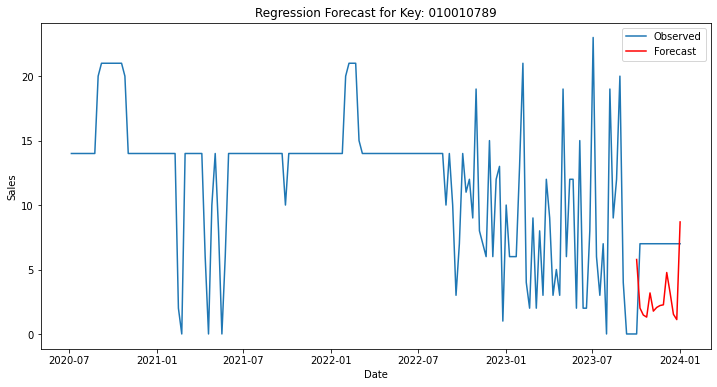

PermissionError: [Errno 13] Permission denied: 'Sales_Forecast_Regression_for_All_Keys.csv'

In [40]:
# Plotting example for a single key's forecast
plt.figure(figsize=(12, 6))
sample_key = merged_data_50['key'].unique()[1]  # Choose the first key for visualization
plt.plot(merged_data_50[merged_data_50['key'] == sample_key]['Date'],
         merged_data_50[merged_data_50['key'] == sample_key]['Sales'], label='Observed')
plt.plot(all_forecasts[all_forecasts['key'] == sample_key]['date'],
         all_forecasts[all_forecasts['key'] == sample_key]['forecast'], label='Forecast', color='red')
plt.title(f'Regression Forecast for Key: {sample_key}')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()

# Save the forecasted results for all keys
all_forecasts.to_csv('Sales_Forecast_Regression_for_All_Keys.csv', index=False)

In [42]:
merged_data_49.head(1)

,Client,Warehouse,Product,Date,Price,Sales,Inventory,key,day,week,month,quarter,year,day_of_week,is_weekend
7119,0.0,1.0,11552.0,2023-09-04,32.67,1.0,0.0,0111552,4,36,9,3,2023,0,0


In [43]:
# Time Since Last Event
merged_data_49['days_since_last_sale'] = merged_data_49.groupby('key')['Date'].diff().dt.days.fillna(0)
# Fourier Series Components (Seasonality)
import math
merged_data_49['sin_day_of_year'] = np.sin(2 * math.pi * merged_data_49['Date'].dt.dayofyear / 365.25)
merged_data_49['cos_day_of_year'] = np.cos(2 * math.pi * merged_data_49['Date'].dt.dayofyear / 365.25)

# Drop unnecessary columns for final dataset
# merged_data_50.drop(columns=['Client_x', 'Warehouse_x', 'Product_x', 'Client_y', 'Warehouse_y', 'Product_y'], errors='ignore', inplace=True)


C:\Users\40104175\AppData\Local\Temp\ipykernel_16140\439873616.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_data_49['days_since_last_sale'] = merged_data_49.groupby('key')['Date'].diff().dt.days.fillna(0)
C:\Users\40104175\AppData\Local\Temp\ipykernel_16140\439873616.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_data_49['sin_day_of_year'] = np.sin(2 * math.pi * merged_data_49['Date'].dt.dayofyear / 365.25)
C:\Users\40104175\AppData\Local\Temp\ipykernel_16140\439873616.py:6: Settin

In [44]:
merged_data_49.columns

Index(['Client', 'Warehouse', 'Product', 'Date', 'Price', 'Sales', 'Inventory',
       'key', 'day', 'week', 'month', 'quarter', 'year', 'day_of_week',
       'is_weekend', 'days_since_last_sale', 'sin_day_of_year',
       'cos_day_of_year'],
      dtype='object')

In [45]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

merged_data_49['week'] = merged_data_49['week'].astype(int)

# # Load the enhanced dataset
# merged_df = pd.read_csv('Enhanced_Data_with_Forecast.csv')

# # Ensure that the 'date' column is in datetime format
# merged_df['date'] = pd.to_datetime(merged_df['date'], errors='coerce')

# Initialize a dataframe to store the forecasts for all keys
all_forecasts1 = pd.DataFrame()

# Define the features and target
target = 'Sales'
features = [
    'day', 'week', 'month', 'quarter', 'year', 'day_of_week',
       'is_weekend', 'days_since_last_sale', 'sin_day_of_year',
       'cos_day_of_year'
]

# Iterate over each unique key
count=0
for key in merged_data_49['key'].unique():
    # Filter data for the current key
    key_data = merged_data_49[merged_data_49['key'] == key].copy()
    
    # Ensure features have no NaNs
    key_data[features] = key_data[features].fillna(method='bfill').fillna(method='ffill')
    
    # Split the data into training and forecasting sets
    # Training data up to the last 13 weeks
    train_data = key_data[key_data['Date'] < key_data['Date'].max() - pd.Timedelta(weeks=13)]
    
    # Features and target for training
    X_train = train_data[features]
    y_train = train_data[target]
    
    # Test data for forecasting (next 13 weeks)
    future_data = key_data[key_data['Date'] >= key_data['Date'].max() - pd.Timedelta(weeks=13)]
    X_test = future_data[features]
    
    # Skip keys with insufficient data
    if len(train_data) < 20:
        continue
    
    # Train the regression model (XGBoost)
    model = XGBRegressor(n_estimators=50, learning_rate=0.1, max_depth=5, random_state=42)
    model.fit(X_train, y_train)
    train_score = model.score(X_train, y_train)
    print(count,train_score)
    count+=1
    
    # Forecast the next 13 weeks using the trained model
    y_pred = model.predict(X_test)
    
    # Create a DataFrame to store the forecast results
    forecast_df = pd.DataFrame({
        'date': future_data['Date'],
        'key': key,
        'forecast': y_pred
    })
    
    # Append the forecast to the all_forecasts dataframe
    all_forecasts1 = pd.concat([all_forecasts1, forecast_df])




C:\Users\40104175\AppData\Local\Temp\ipykernel_16140\1998647664.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_data_49['week'] = merged_data_49['week'].astype(int)


0 0.9974277569241059
1 0.9966441634695775
2 0.997238810084994
3 0.9982108521997612
4 0.9977553239833938
5 0.9912593731924532
6 0.9975204154421982
7 0.9947799616775634
8 0.998163850520728
9 0.9951796910419921
10 0.9970368848023443
11 0.9943030502278335
12 0.9981672718720584
13 0.9938593555127003
14 0.9962682844601847
15 0.9941358192417001
16 0.9944424867839221
17 0.9959839588219591
18 0.9965553685932519
19 0.9986504108855297
20 0.9990413639253681
21 0.9978540335190738
22 0.998202585123253
23 0.9981225294845585
24 0.9959375712756943
25 0.9953826650631583
26 0.9941742353037657
27 0.9969136694299281
28 0.9979835501623895
29 0.9941168281314882
30 0.9966482911725648
31 0.9902870871248722
32 0.9985608771122232
33 0.9954396687989855
34 0.995399447226647
35 0.9972254346439069
36 0.9982076166118199
37 0.9964564999982357
38 0.9982052937264778
39 0.9948072312721523
40 0.9976065120674178
41 0.9972254346439069
42 0.9989034026213874
43 0.9978045742186548
44 0.9986197071784478
45 0.996738316576263
46 

364 0.9988860740058212
365 0.99642158888285
366 0.997900884082083
367 0.996005293803168
368 0.9984689897713388
369 0.996037404454598
370 0.9952146926932018
371 0.9965238179115136
372 0.9956245146564773
373 0.9937676788420912
374 0.9913188835508645
375 0.9928539124791502
376 0.9927886810565966
377 0.9968633380444143
378 0.9940708486247033
379 0.9986347133127883
380 0.9982796233870288
381 0.9945201993784292
382 0.9946952693769613
383 0.9877810923874133
384 0.9930957023323089
385 0.9959474352799523
386 0.9969418463162765
387 0.994372862614072
388 0.9979983816010334
389 0.9984132972461337
390 0.9991033185669554
391 0.995977749189713
392 0.991345370325221
393 0.9894207214465556
394 0.9956925300264358
395 0.9935191458075437
396 0.9983127745992227
397 0.9866806487921969
398 0.9928969911276395
399 0.9880642662913834
400 0.9847696179965535
401 0.9966643077501804
402 0.9956955256440391
403 0.9974375974490574
404 0.997752763614264
405 0.9909488990931427
406 0.9974454264723647
407 0.99622908660598

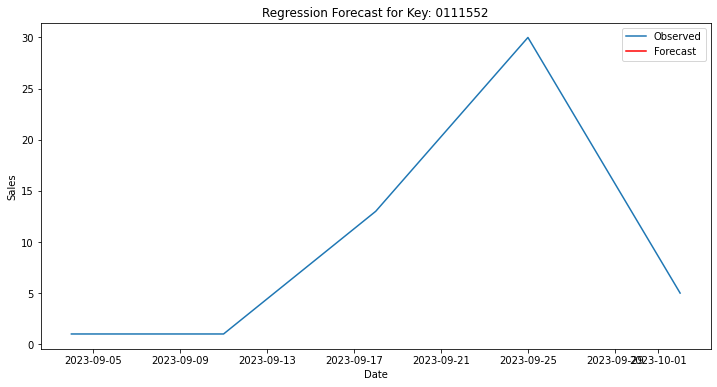

In [47]:
# Plotting example for a single key's forecast
plt.figure(figsize=(12, 6))
sample_key = merged_data_49['key'].unique()[0]  # Choose the first key for visualization
plt.plot(merged_data_49[merged_data_49['key'] == sample_key]['Date'],
         merged_data_49[merged_data_49['key'] == sample_key]['Sales'], label='Observed')
plt.plot(all_forecasts1[all_forecasts1['key'] == sample_key]['date'],
         all_forecasts1[all_forecasts1['key'] == sample_key]['forecast'], label='Forecast', color='red')
plt.title(f'Regression Forecast for Key: {sample_key}')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()

# Save the forecasted results for all keys
all_forecasts1.to_csv('Sales_Forecast_Regression_for_All_Keys_49.csv', index=False)